In [1]:

from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from functools import partial
from keras import backend as K
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import concatenate
from keras.utils.data_utils import get_file
from tensorflow.keras.utils import plot_model
from keras.utils.layer_utils import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.layers import Activation, AveragePooling2D, BatchNormalization, Concatenate,Conv2D,Dense,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D,Input,Lambda,MaxPooling2D



In [4]:
import os
import numpy as np
from tensorflow.keras.applications import DenseNet121, ResNet152
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tqdm import tqdm

In [6]:
# Setting paths and showing the number of images
falciparum = os.listdir("final_dataset1/Falciparum")
falciparum_path = "final_dataset1/Falciparum"
print("Length of falciparum data = ", len(falciparum), 'images')
vivax = os.listdir("final_dataset1/Vivax")
vivax_path = "final_dataset1/Vivax"
print("Length of vivax data = ", len(vivax), 'images')
uninfected = os.listdir("final_dataset1/Uninfected")
uninfected_path = "final_dataset1/Uninfected"
print("Length of uninfected data = ", len(uninfected), 'images')


Length of falciparum data =  965 images
Length of vivax data =  965 images
Length of uninfected data =  965 images


# : Gray-world Normalization

In [11]:
import os
import cv2
import numpy as np

# Function to perform Gray World normalization on an image
def gray_world_normalization(image):
    # Convert image to float32
    image = image.astype(np.float32)
    
    # Calculate average color for each channel
    avg_r = np.mean(image[:,:,0])
    avg_g = np.mean(image[:,:,1])
    avg_b = np.mean(image[:,:,2])
    
    # Calculate the gray world factor
    avg_gray = (avg_r + avg_g + avg_b) / 3.0
    scale_r = avg_gray / avg_r
    scale_g = avg_gray / avg_g
    scale_b = avg_gray / avg_b
    
    # Apply scaling to each channel
    image[:,:,0] *= scale_r
    image[:,:,1] *= scale_g
    image[:,:,2] *= scale_b
    
    # Clip the pixel values to ensure they remain in [0, 255] range
    image = np.clip(image, 0, 255)
    
    # Convert back to uint8
    image = image.astype(np.uint8)
    
    return image


In [12]:
# Define paths
falciparum_path = "final_dataset1/Falciparum"
vivax_path = "final_dataset1/Vivax"
uninfected_path = "final_dataset1/Uninfected"

# Define output directories for normalized images
output_falciparum_path = "final_dataset1_normalized/Falciparum"
output_vivax_path = "final_dataset1_normalized/Vivax"
output_uninfected_path = "final_dataset1_normalized/Uninfected"

# Create output directories if they don't exist
os.makedirs(output_falciparum_path, exist_ok=True)
os.makedirs(output_vivax_path, exist_ok=True)
os.makedirs(output_uninfected_path, exist_ok=True)

In [7]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_samples(class_path, output_class_path, class_name, num_samples=5):
    # Get list of image filenames
    original_image_files = os.listdir(class_path)
    normalized_image_files = os.listdir(output_class_path)
    # Select random samples
    original_sample_files = random.sample(original_image_files, num_samples)
    normalized_sample_files = random.sample(normalized_image_files, num_samples)
    # Plot the images
    plt.figure(figsize=(15, 6))
    plt.suptitle('Samples from ' + class_name + ' Class', fontsize=16)
    for i in range(num_samples):
        # Plot original image
        plt.subplot(2, num_samples, i+1)
        original_img_path = os.path.join(class_path, original_sample_files[i])
        original_img = mpimg.imread(original_img_path)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title('Original')
        # Plot normalized image
        plt.subplot(2, num_samples, num_samples+i+1)
        normalized_img_path = os.path.join(output_class_path, normalized_sample_files[i])
        normalized_img = mpimg.imread(normalized_img_path)
        plt.imshow(normalized_img)
        plt.axis('off')
        plt.title('Normalized')
    plt.show()

# Display samples from each class
display_samples(falciparum_path, output_falciparum_path, 'Falciparum')
display_samples(vivax_path, output_vivax_path, 'Vivax')
display_samples(uninfected_path, output_uninfected_path, 'Uninfected')


NameError: name 'output_falciparum_path' is not defined

In [13]:
# Iterate over images in Falciparum dataset
for img_name in os.listdir(falciparum_path):
    img_path = os.path.join(falciparum_path, img_name)
    image = cv2.imread(img_path)
    if image is not None:
        # Perform Gray World normalization
        normalized_image = gray_world_normalization(image)
        # Save the normalized image to the output directory
        output_img_path = os.path.join(output_falciparum_path, img_name)
        cv2.imwrite(output_img_path, normalized_image)

# Repeat the same process for the Vivax and Uninfected datasets
for img_name in os.listdir(vivax_path):
    img_path = os.path.join(vivax_path, img_name)
    image = cv2.imread(img_path)
    if image is not None:
        normalized_image = gray_world_normalization(image)
        output_img_path = os.path.join(output_vivax_path, img_name)
        cv2.imwrite(output_img_path, normalized_image)

for img_name in os.listdir(uninfected_path):
    img_path = os.path.join(uninfected_path, img_name)
    image = cv2.imread(img_path)
    if image is not None:
        normalized_image = gray_world_normalization(image)
        output_img_path = os.path.join(output_uninfected_path, img_name)
        cv2.imwrite(output_img_path, normalized_image)

# ResNet152


In [29]:
def conv2d_bn(x, filters, kernel_size, strides=1, padding='same', activation='relu', use_bias=False, name=None):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias, name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation is not None:
        ac_name = _generate_layer_name('Activation', prefix=name)
        x = Activation(activation, name=ac_name)(x)
    return x


def _generate_layer_name(name, branch_idx=None, prefix=None):
    if prefix is None:
        return None
    if branch_idx is None:
        return '_'.join((prefix, name))
    return '_'.join((prefix, 'Branch', str(branch_idx), name))


def _inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    if block_idx is None:
        prefix = None
    else:
        prefix = '_'.join((block_type, str(block_idx)))
    name_fmt = partial(_generate_layer_name, prefix=prefix)
    if block_type == 'Block35':
        branch_0 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 32, 3, name=name_fmt('Conv2d_0b_3x3', 1))
        branch_2 = conv2d_bn(x, 32, 1, name=name_fmt('Conv2d_0a_1x1', 2))
        branch_2 = conv2d_bn(branch_2, 48, 3, name=name_fmt('Conv2d_0b_3x3', 2))
        branch_2 = conv2d_bn(branch_2, 64, 3, name=name_fmt('Conv2d_0c_3x3', 2))
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'Block17':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 128, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 160, [1, 7], name=name_fmt('Conv2d_0b_1x7', 1))
        branch_1 = conv2d_bn(branch_1, 192, [7, 1], name=name_fmt('Conv2d_0c_7x1', 1))
        branches = [branch_0, branch_1]
    elif block_type == 'Block8':
        branch_0 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_1x1', 0))
        branch_1 = conv2d_bn(x, 192, 1, name=name_fmt('Conv2d_0a_1x1', 1))
        branch_1 = conv2d_bn(branch_1, 224, [1, 3], name=name_fmt('Conv2d_0b_1x3', 1))
        branch_1 = conv2d_bn(branch_1, 256, [3, 1], name=name_fmt('Conv2d_0c_3x1', 1))
        branches = [branch_0, branch_1]
    else:
        raise ValueError(str(block_type))

    mixed = Concatenate(axis=channel_axis, name=name_fmt('Concatenate'))(branches)
    up = conv2d_bn(mixed,K.int_shape(x)[channel_axis],1,activation=None,use_bias=True,name=name_fmt('Conv2d_1x1'))
    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:],arguments={'scale': scale},name=name_fmt('ScaleSum'))([x, up])
    if activation is not None:
        x = Activation(activation, name=name_fmt('Activation'))(x)
    return x


def InceptionResNetV2(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,dropout_keep_prob=0.8):

    if weights not in {'imagenet', None}:
        raise ValueError('Error')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('Error')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,default_size=299,min_size=139,data_format=K.image_data_format(),require_flatten=False,weights=weights)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Stem block: 35 x 35 x 192
    x = conv2d_bn(img_input, 32, 3, strides=2, padding='valid', name='Conv2d_1a_3x3')
    x = conv2d_bn(x, 32, 3, padding='valid', name='Conv2d_2a_3x3')
    x = conv2d_bn(x, 64, 3, name='Conv2d_2b_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_3a_3x3')(x)
    x = conv2d_bn(x, 80, 1, padding='valid', name='Conv2d_3b_1x1')
    x = conv2d_bn(x, 192, 3, padding='valid', name='Conv2d_4a_3x3')
    x = MaxPooling2D(3, strides=2, name='MaxPool_5a_3x3')(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 320
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    name_fmt = partial(_generate_layer_name, prefix='Mixed_5b')
    branch_0 = conv2d_bn(x, 96, 1, name=name_fmt('Conv2d_1x1', 0))
    branch_1 = conv2d_bn(x, 48, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 64, 5, name=name_fmt('Conv2d_0b_5x5', 1))
    branch_2 = conv2d_bn(x, 64, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 96, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2, 96, 3, name=name_fmt('Conv2d_0c_3x3', 2))
    branch_pool = AveragePooling2D(3, strides=1, padding='same', name=name_fmt('AvgPool_0a_3x3', 3))(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, name=name_fmt('Conv2d_0b_1x1', 3))
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_5b')(branches)

    # 10x Block35 (Inception-ResNet-A block): 35 x 35 x 320
    for block_idx in range(1, 11):
        x = _inception_resnet_block(x, scale=0.17, block_type='Block35', block_idx=block_idx)
          # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    name_fmt = partial(_generate_layer_name, prefix='Mixed_6a')
    branch_0 = conv2d_bn(x,384, 3, strides=2, padding='valid', name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1, 256, 3, name=name_fmt('Conv2d_0b_3x3', 1))
    branch_1 = conv2d_bn(branch_1,384,3,strides=2,padding='valid',name=name_fmt('Conv2d_1a_3x3', 1))
    branch_pool = MaxPooling2D(3,strides=2,padding='valid',name=name_fmt('MaxPool_1a_3x3', 2))(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_6a')(branches)

    # 20x Block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = _inception_resnet_block(x,scale=0.1,block_type='Block17',block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    name_fmt = partial(_generate_layer_name, prefix='Mixed_7a')
    branch_0 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 0))
    branch_0 = conv2d_bn(branch_0,384,3,strides=2,padding='valid',name=name_fmt('Conv2d_1a_3x3', 0))
    branch_1 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 1))
    branch_1 = conv2d_bn(branch_1,288,3,strides=2,padding='valid',name=name_fmt('Conv2d_1a_3x3', 1))
    branch_2 = conv2d_bn(x, 256, 1, name=name_fmt('Conv2d_0a_1x1', 2))
    branch_2 = conv2d_bn(branch_2, 288, 3, name=name_fmt('Conv2d_0b_3x3', 2))
    branch_2 = conv2d_bn(branch_2,320,3,strides=2,padding='valid',name=name_fmt('Conv2d_1a_3x3', 2))
    branch_pool = MaxPooling2D(3,strides=2,padding='valid',name=name_fmt('MaxPool_1a_3x3', 3))(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='Mixed_7a')(branches)

    # 10x Block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = _inception_resnet_block(x,scale=0.2,block_type='Block8',block_idx=block_idx)
    x = _inception_resnet_block(x,scale=1.,activation=None,block_type='Block8',block_idx=10)

    # Final convolution block
    x = conv2d_bn(x, 1536, 1, name='Conv2d_7b_1x1')

    if include_top:
        # Classification block
        x = GlobalAveragePooling2D(name='AvgPool')(x)
        x = Dropout(1.0 - dropout_keep_prob, name='Dropout')(x)
        x = Dense(classes, name='Logits')(x)
        x = Activation('softmax', name='Predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D(name='AvgPool')(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D(name='MaxPool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model
    model = Model(inputs, x, name='inception_resnet_v2')

    return model


In [40]:

model = InceptionResNetV2(include_top=False)

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, None, None,   864         ['input_8[0][0]']                
                                32)                                                               
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, None, None,   96         ['Conv2d_1a_3x3[0][0]']          
 Normalization)                 32)                                             

                                                                                                  
 Mixed_5b_Branch_2_Conv2d_0b_3x  (None, None, None,   0          ['Mixed_5b_Branch_2_Conv2d_0b_3x3
 3_Activation (Activation)      96)                              _BatchNorm[0][0]']               
                                                                                                  
 Mixed_5b_Branch_3_AvgPool_0a_3  (None, None, None,   0          ['MaxPool_5a_3x3[0][0]']         
 x3 (AveragePooling2D)          192)                                                              
                                                                                                  
 Mixed_5b_Branch_0_Conv2d_1x1 (  (None, None, None,   18432      ['MaxPool_5a_3x3[0][0]']         
 Conv2D)                        96)                                                               
                                                                                                  
 Mixed_5b_

 x3_Activation (Activation)     48)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_1_Branch_0_Conv2d_1x1   (None, None, None,   10240      ['Mixed_5b[0][0]']               
 (Conv2D)                       32)                                                               
                                                                                                  
 Block35_1_Branch_1_Conv2d_0b_3  (None, None, None,   9216       ['Block35_1_Branch_1_Conv2d_0a_1x
 x3 (Conv2D)                    32)                              1_Activation[0][0]']             
                                                                                                  
 Block35_1_Branch_2_Conv2d_0c_3  (None, None, None,   27648      ['Block35_1_Branch_2_Conv2d_0b_3x
 x3 (Conv2D)                    64)                              3_Activation[0][0]']             
          

 Block35_2_Branch_2_Conv2d_0c_3  (None, None, None,   27648      ['Block35_2_Branch_2_Conv2d_0b_3x
 x3 (Conv2D)                    64)                              3_Activation[0][0]']             
                                                                                                  
 Block35_2_Branch_0_Conv2d_1x1_  (None, None, None,   96         ['Block35_2_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  32)                             ][0]']                           
                                                                                                  
 Block35_2_Branch_1_Conv2d_0b_3  (None, None, None,   96         ['Block35_2_Branch_1_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_2

 on)                                                                                              
                                                                                                  
 Block35_3_Branch_2_Conv2d_0c_3  (None, None, None,   192        ['Block35_3_Branch_2_Conv2d_0c_3x
 x3_BatchNorm (BatchNormalizati  64)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_3_Branch_0_Conv2d_1x1_  (None, None, None,   0          ['Block35_3_Branch_0_Conv2d_1x1_B
 Activation (Activation)        32)                              atchNorm[0][0]']                 
                                                                                                  
 Block35_3_Branch_1_Conv2d_0b_3  (None, None, None,   0          ['Block35_3_Branch_1_Conv2d_0b_3x
 x3_Activa

                                                                                                  
 Block35_4_Branch_1_Conv2d_0b_3  (None, None, None,   0          ['Block35_4_Branch_1_Conv2d_0b_3x
 x3_Activation (Activation)     32)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_4_Branch_2_Conv2d_0c_3  (None, None, None,   0          ['Block35_4_Branch_2_Conv2d_0c_3x
 x3_Activation (Activation)     64)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_4_Concatenate (Concate  (None, None, None,   0          ['Block35_4_Branch_0_Conv2d_1x1_A
 nate)                          128)                             ctivation[0][0]',                
                                                                  'Block35_4_Branch_1_Conv2d_0b_3x
          

 nate)                          128)                             ctivation[0][0]',                
                                                                  'Block35_5_Branch_1_Conv2d_0b_3x
                                                                 3_Activation[0][0]',             
                                                                  'Block35_5_Branch_2_Conv2d_0c_3x
                                                                 3_Activation[0][0]']             
                                                                                                  
 Block35_5_Conv2d_1x1 (Conv2D)  (None, None, None,   41280       ['Block35_5_Concatenate[0][0]']  
                                320)                                                              
                                                                                                  
 Block35_5_ScaleSum (Lambda)    (None, None, None,   0           ['Block35_4_Activation[0][0]',   
          

                                                                                                  
 Block35_6_ScaleSum (Lambda)    (None, None, None,   0           ['Block35_5_Activation[0][0]',   
                                320)                              'Block35_6_Conv2d_1x1[0][0]']   
                                                                                                  
 Block35_6_Activation (Activati  (None, None, None,   0          ['Block35_6_ScaleSum[0][0]']     
 on)                            320)                                                              
                                                                                                  
 Block35_7_Branch_2_Conv2d_0a_1  (None, None, None,   10240      ['Block35_6_Activation[0][0]']   
 x1 (Conv2D)                    32)                                                               
                                                                                                  
 Block35_7

 x1 (Conv2D)                    32)                                                               
                                                                                                  
 Block35_8_Branch_2_Conv2d_0a_1  (None, None, None,   96         ['Block35_8_Branch_2_Conv2d_0a_1x
 x1_BatchNorm (BatchNormalizati  32)                             1[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_8_Branch_2_Conv2d_0a_1  (None, None, None,   0          ['Block35_8_Branch_2_Conv2d_0a_1x
 x1_Activation (Activation)     32)                              1_BatchNorm[0][0]']              
                                                                                                  
 Block35_8_Branch_1_Conv2d_0a_1  (None, None, None,   10240      ['Block35_7_Activation[0][0]']   
 x1 (Conv2

                                                                                                  
 Block35_9_Branch_1_Conv2d_0a_1  (None, None, None,   10240      ['Block35_8_Activation[0][0]']   
 x1 (Conv2D)                    32)                                                               
                                                                                                  
 Block35_9_Branch_2_Conv2d_0b_3  (None, None, None,   13824      ['Block35_9_Branch_2_Conv2d_0a_1x
 x3 (Conv2D)                    48)                              1_Activation[0][0]']             
                                                                                                  
 Block35_9_Branch_1_Conv2d_0a_1  (None, None, None,   96         ['Block35_9_Branch_1_Conv2d_0a_1x
 x1_BatchNorm (BatchNormalizati  32)                             1[0][0]']                        
 on)                                                                                              
          

 1x1_BatchNorm (BatchNormalizat  32)                             x1[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block35_10_Branch_2_Conv2d_0b_  (None, None, None,   144        ['Block35_10_Branch_2_Conv2d_0b_3
 3x3_BatchNorm (BatchNormalizat  48)                             x3[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block35_10_Branch_1_Conv2d_0a_  (None, None, None,   0          ['Block35_10_Branch_1_Conv2d_0a_1
 1x1_Activation (Activation)    32)                              x1_BatchNorm[0][0]']             
                                                                                                  
 Block35_1

 3 (Conv2D)                     384)                             _Activation[0][0]']              
                                                                                                  
 Mixed_6a_Branch_0_Conv2d_1a_3x  (None, None, None,   1152       ['Mixed_6a_Branch_0_Conv2d_1a_3x3
 3_BatchNorm (BatchNormalizatio  384)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Mixed_6a_Branch_1_Conv2d_1a_3x  (None, None, None,   1152       ['Mixed_6a_Branch_1_Conv2d_1a_3x3
 3_BatchNorm (BatchNormalizatio  384)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Mixed_6a_

 x1_BatchNorm (BatchNormalizati  128)                            1[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block17_2_Branch_1_Conv2d_0a_1  (None, None, None,   0          ['Block17_2_Branch_1_Conv2d_0a_1x
 x1_Activation (Activation)     128)                             1_BatchNorm[0][0]']              
                                                                                                  
 Block17_2_Branch_1_Conv2d_0b_1  (None, None, None,   143360     ['Block17_2_Branch_1_Conv2d_0a_1x
 x7 (Conv2D)                    160)                             1_Activation[0][0]']             
                                                                                                  
 Block17_2_Branch_1_Conv2d_0b_1  (None, None, None,   480        ['Block17_2_Branch_1_Conv2d_0b_1x
 x7_BatchN

 Activation (Activation)        192)                             atchNorm[0][0]']                 
                                                                                                  
 Block17_3_Branch_1_Conv2d_0c_7  (None, None, None,   0          ['Block17_3_Branch_1_Conv2d_0c_7x
 x1_Activation (Activation)     192)                             1_BatchNorm[0][0]']              
                                                                                                  
 Block17_3_Concatenate (Concate  (None, None, None,   0          ['Block17_3_Branch_0_Conv2d_1x1_A
 nate)                          384)                             ctivation[0][0]',                
                                                                  'Block17_3_Branch_1_Conv2d_0c_7x
                                                                 1_Activation[0][0]']             
                                                                                                  
 Block17_3

 x7 (Conv2D)                    160)                             1_Activation[0][0]']             
                                                                                                  
 Block17_5_Branch_1_Conv2d_0b_1  (None, None, None,   480        ['Block17_5_Branch_1_Conv2d_0b_1x
 x7_BatchNorm (BatchNormalizati  160)                            7[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block17_5_Branch_1_Conv2d_0b_1  (None, None, None,   0          ['Block17_5_Branch_1_Conv2d_0b_1x
 x7_Activation (Activation)     160)                             7_BatchNorm[0][0]']              
                                                                                                  
 Block17_5_Branch_0_Conv2d_1x1   (None, None, None,   208896     ['Block17_4_Activation[0][0]']   
 (Conv2D) 

                                                                  'Block17_6_Branch_1_Conv2d_0c_7x
                                                                 1_Activation[0][0]']             
                                                                                                  
 Block17_6_Conv2d_1x1 (Conv2D)  (None, None, None,   418880      ['Block17_6_Concatenate[0][0]']  
                                1088)                                                             
                                                                                                  
 Block17_6_ScaleSum (Lambda)    (None, None, None,   0           ['Block17_5_Activation[0][0]',   
                                1088)                             'Block17_6_Conv2d_1x1[0][0]']   
                                                                                                  
 Block17_6_Activation (Activati  (None, None, None,   0          ['Block17_6_ScaleSum[0][0]']     
 on)      

 x7_Activation (Activation)     160)                             7_BatchNorm[0][0]']              
                                                                                                  
 Block17_8_Branch_0_Conv2d_1x1   (None, None, None,   208896     ['Block17_7_Activation[0][0]']   
 (Conv2D)                       192)                                                              
                                                                                                  
 Block17_8_Branch_1_Conv2d_0c_7  (None, None, None,   215040     ['Block17_8_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    192)                             7_Activation[0][0]']             
                                                                                                  
 Block17_8_Branch_0_Conv2d_1x1_  (None, None, None,   576        ['Block17_8_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  192)                            ][0]']                           
          

                                1088)                             'Block17_9_Conv2d_1x1[0][0]']   
                                                                                                  
 Block17_9_Activation (Activati  (None, None, None,   0          ['Block17_9_ScaleSum[0][0]']     
 on)                            1088)                                                             
                                                                                                  
 Block17_10_Branch_1_Conv2d_0a_  (None, None, None,   139264     ['Block17_9_Activation[0][0]']   
 1x1 (Conv2D)                   128)                                                              
                                                                                                  
 Block17_10_Branch_1_Conv2d_0a_  (None, None, None,   384        ['Block17_10_Branch_1_Conv2d_0a_1
 1x1_BatchNorm (BatchNormalizat  128)                            x1[0][0]']                       
 ion)     

 7x1 (Conv2D)                   192)                             x7_Activation[0][0]']            
                                                                                                  
 Block17_11_Branch_0_Conv2d_1x1  (None, None, None,   576        ['Block17_11_Branch_0_Conv2d_1x1[
 _BatchNorm (BatchNormalization  192)                            0][0]']                          
 )                                                                                                
                                                                                                  
 Block17_11_Branch_1_Conv2d_0c_  (None, None, None,   576        ['Block17_11_Branch_1_Conv2d_0c_7
 7x1_BatchNorm (BatchNormalizat  192)                            x1[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block17_1

                                                                                                  
 Block17_13_Branch_1_Conv2d_0a_  (None, None, None,   139264     ['Block17_12_Activation[0][0]']  
 1x1 (Conv2D)                   128)                                                              
                                                                                                  
 Block17_13_Branch_1_Conv2d_0a_  (None, None, None,   384        ['Block17_13_Branch_1_Conv2d_0a_1
 1x1_BatchNorm (BatchNormalizat  128)                            x1[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block17_13_Branch_1_Conv2d_0a_  (None, None, None,   0          ['Block17_13_Branch_1_Conv2d_0a_1
 1x1_Activation (Activation)    128)                             x1_BatchNorm[0][0]']             
          

 )                                                                                                
                                                                                                  
 Block17_14_Branch_1_Conv2d_0c_  (None, None, None,   576        ['Block17_14_Branch_1_Conv2d_0c_7
 7x1_BatchNorm (BatchNormalizat  192)                            x1[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block17_14_Branch_0_Conv2d_1x1  (None, None, None,   0          ['Block17_14_Branch_0_Conv2d_1x1_
 _Activation (Activation)       192)                             BatchNorm[0][0]']                
                                                                                                  
 Block17_14_Branch_1_Conv2d_0c_  (None, None, None,   0          ['Block17_14_Branch_1_Conv2d_0c_7
 7x1_Activ

 Block17_16_Branch_1_Conv2d_0a_  (None, None, None,   384        ['Block17_16_Branch_1_Conv2d_0a_1
 1x1_BatchNorm (BatchNormalizat  128)                            x1[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block17_16_Branch_1_Conv2d_0a_  (None, None, None,   0          ['Block17_16_Branch_1_Conv2d_0a_1
 1x1_Activation (Activation)    128)                             x1_BatchNorm[0][0]']             
                                                                                                  
 Block17_16_Branch_1_Conv2d_0b_  (None, None, None,   143360     ['Block17_16_Branch_1_Conv2d_0a_1
 1x7 (Conv2D)                   160)                             x1_Activation[0][0]']            
                                                                                                  
 Block17_1

 ion)                                                                                             
                                                                                                  
 Block17_17_Branch_0_Conv2d_1x1  (None, None, None,   0          ['Block17_17_Branch_0_Conv2d_1x1_
 _Activation (Activation)       192)                             BatchNorm[0][0]']                
                                                                                                  
 Block17_17_Branch_1_Conv2d_0c_  (None, None, None,   0          ['Block17_17_Branch_1_Conv2d_0c_7
 7x1_Activation (Activation)    192)                             x1_BatchNorm[0][0]']             
                                                                                                  
 Block17_17_Concatenate (Concat  (None, None, None,   0          ['Block17_17_Branch_0_Conv2d_1x1_
 enate)                         384)                             Activation[0][0]',               
          

 Block17_19_Branch_1_Conv2d_0a_  (None, None, None,   0          ['Block17_19_Branch_1_Conv2d_0a_1
 1x1_Activation (Activation)    128)                             x1_BatchNorm[0][0]']             
                                                                                                  
 Block17_19_Branch_1_Conv2d_0b_  (None, None, None,   143360     ['Block17_19_Branch_1_Conv2d_0a_1
 1x7 (Conv2D)                   160)                             x1_Activation[0][0]']            
                                                                                                  
 Block17_19_Branch_1_Conv2d_0b_  (None, None, None,   480        ['Block17_19_Branch_1_Conv2d_0b_1
 1x7_BatchNorm (BatchNormalizat  160)                            x7[0][0]']                       
 ion)                                                                                             
                                                                                                  
 Block17_1

                                                                                                  
 Block17_20_Branch_1_Conv2d_0c_  (None, None, None,   0          ['Block17_20_Branch_1_Conv2d_0c_7
 7x1_Activation (Activation)    192)                             x1_BatchNorm[0][0]']             
                                                                                                  
 Block17_20_Concatenate (Concat  (None, None, None,   0          ['Block17_20_Branch_0_Conv2d_1x1_
 enate)                         384)                             Activation[0][0]',               
                                                                  'Block17_20_Branch_1_Conv2d_0c_7
                                                                 x1_Activation[0][0]']            
                                                                                                  
 Block17_20_Conv2d_1x1 (Conv2D)  (None, None, None,   418880     ['Block17_20_Concatenate[0][0]'] 
          

 3_Activation (Activation)      288)                             _BatchNorm[0][0]']               
                                                                                                  
 Mixed_7a_Branch_2_Conv2d_1a_3x  (None, None, None,   0          ['Mixed_7a_Branch_2_Conv2d_1a_3x3
 3_Activation (Activation)      320)                             _BatchNorm[0][0]']               
                                                                                                  
 Mixed_7a_Branch_3_MaxPool_1a_3  (None, None, None,   0          ['Block17_20_Activation[0][0]']  
 x3 (MaxPooling2D)              1088)                                                             
                                                                                                  
 Mixed_7a (Concatenate)         (None, None, None,   0           ['Mixed_7a_Branch_0_Conv2d_1a_3x3
                                2080)                            _Activation[0][0]',              
          

 Block8_2_Branch_1_Conv2d_0b_1x  (None, None, None,   672        ['Block8_2_Branch_1_Conv2d_0b_1x3
 3_BatchNorm (BatchNormalizatio  224)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Block8_2_Branch_1_Conv2d_0b_1x  (None, None, None,   0          ['Block8_2_Branch_1_Conv2d_0b_1x3
 3_Activation (Activation)      224)                             _BatchNorm[0][0]']               
                                                                                                  
 Block8_2_Branch_0_Conv2d_1x1 (  (None, None, None,   399360     ['Block8_1_Activation[0][0]']    
 Conv2D)                        192)                                                              
                                                                                                  
 Block8_2_

                                                                                                  
 Block8_3_Conv2d_1x1 (Conv2D)   (None, None, None,   933920      ['Block8_3_Concatenate[0][0]']   
                                2080)                                                             
                                                                                                  
 Block8_3_ScaleSum (Lambda)     (None, None, None,   0           ['Block8_2_Activation[0][0]',    
                                2080)                             'Block8_3_Conv2d_1x1[0][0]']    
                                                                                                  
 Block8_3_Activation (Activatio  (None, None, None,   0          ['Block8_3_ScaleSum[0][0]']      
 n)                             2080)                                                             
                                                                                                  
 Block8_4_

 Block8_5_Branch_0_Conv2d_1x1 (  (None, None, None,   399360     ['Block8_4_Activation[0][0]']    
 Conv2D)                        192)                                                              
                                                                                                  
 Block8_5_Branch_1_Conv2d_0c_3x  (None, None, None,   172032     ['Block8_5_Branch_1_Conv2d_0b_1x3
 1 (Conv2D)                     256)                             _Activation[0][0]']              
                                                                                                  
 Block8_5_Branch_0_Conv2d_1x1_B  (None, None, None,   576        ['Block8_5_Branch_0_Conv2d_1x1[0]
 atchNorm (BatchNormalization)  192)                             [0]']                            
                                                                                                  
 Block8_5_Branch_1_Conv2d_0c_3x  (None, None, None,   768        ['Block8_5_Branch_1_Conv2d_0c_3x1
 1_BatchNo

 Block8_6_Activation (Activatio  (None, None, None,   0          ['Block8_6_ScaleSum[0][0]']      
 n)                             2080)                                                             
                                                                                                  
 Block8_7_Branch_1_Conv2d_0a_1x  (None, None, None,   399360     ['Block8_6_Activation[0][0]']    
 1 (Conv2D)                     192)                                                              
                                                                                                  
 Block8_7_Branch_1_Conv2d_0a_1x  (None, None, None,   576        ['Block8_7_Branch_1_Conv2d_0a_1x1
 1_BatchNorm (BatchNormalizatio  192)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Block8_7_

 atchNorm (BatchNormalization)  192)                             [0]']                            
                                                                                                  
 Block8_8_Branch_1_Conv2d_0c_3x  (None, None, None,   768        ['Block8_8_Branch_1_Conv2d_0c_3x1
 1_BatchNorm (BatchNormalizatio  256)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Block8_8_Branch_0_Conv2d_1x1_A  (None, None, None,   0          ['Block8_8_Branch_0_Conv2d_1x1_Ba
 ctivation (Activation)         192)                             tchNorm[0][0]']                  
                                                                                                  
 Block8_8_Branch_1_Conv2d_0c_3x  (None, None, None,   0          ['Block8_8_Branch_1_Conv2d_0c_3x1
 1_Activat

 x1_BatchNorm (BatchNormalizati  192)                            1[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block8_10_Branch_1_Conv2d_0a_1  (None, None, None,   0          ['Block8_10_Branch_1_Conv2d_0a_1x
 x1_Activation (Activation)     192)                             1_BatchNorm[0][0]']              
                                                                                                  
 Block8_10_Branch_1_Conv2d_0b_1  (None, None, None,   129024     ['Block8_10_Branch_1_Conv2d_0a_1x
 x3 (Conv2D)                    224)                             1_Activation[0][0]']             
                                                                                                  
 Block8_10_Branch_1_Conv2d_0b_1  (None, None, None,   672        ['Block8_10_Branch_1_Conv2d_0b_1x
 x3_BatchN

In [6]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

# Load the InceptionResNetV2 model without the top classification layers
base_model = InceptionResNetV2(input_shape=(130, 130, 3), include_top=False, weights='imagenet')

# Add your custom classification layers on top of the base InceptionResNetV2 model
x = GlobalAveragePooling2D()(base_model.output)
# Add a Dense output layer with the appropriate number of neurons for the number of classes in your problem
num_classes = 3  # Change this according to your problem
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with RMSprop optimizer and categorical crossentropy loss
# Use learning_rate instead of lr
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


219055592/219055592 [==============================] - 44s 0us/step


In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting paths and showing the number of images
falciparum_path = "final_dataset1_normalized/Falciparum"
vivax_path = "final_dataset1_normalized/Vivax"
uninfected_path = "final_dataset1_normalized/Uninfected"

falciparum = os.listdir(falciparum_path)
print("Length of falciparum data =", len(falciparum), 'images')

vivax = os.listdir(vivax_path)
print("Length of vivax data =", len(vivax), 'images')

uninfected = os.listdir(uninfected_path)
print("Length of uninfected data =", len(uninfected), 'images')

# Define data generators for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "final_dataset1_normalized",
    target_size=(130, 130),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    "final_dataset1_normalized",
    target_size=(130, 130),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32)

# Extract validation accuracy for each epoch
val_acc = history.history['val_accuracy']
print("Validation Accuracy for Each Epoch:", val_acc)


Length of falciparum data = 965 images
Length of vivax data = 965 images
Length of uninfected data = 965 images
Found 2316 images belonging to 3 classes.
Found 579 images belonging to 3 classes.
Epoch 1/10
72/72 [==============================] - 2296s 31s/step - loss: 0.0719 - accuracy: 0.9759 - val_loss: 0.0924 - val_accuracy: 0.9948
Epoch 2/10
72/72 [==============================] - 1431s 20s/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 3/10
72/72 [==============================] - 2429s 34s/step - loss: 7.4810e-04 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 4/10
72/72 [==============================] - 555s 8s/step - loss: 1.4780e-04 - accuracy: 1.0000 - val_loss: 8.2150e-04 - val_accuracy: 1.0000
Epoch 5/10
72/72 [==============================] - 558s 8s/step - loss: 1.3078e-04 - accuracy: 1.0000 - val_loss: 2.5601e-04 - val_accuracy: 1.0000
Epoch 6/10
72/72 [==============================] - 2983s 42s/step - loss:

C:\Users\avisi\AppData\Local\Temp\ipykernel_20436\697373770.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


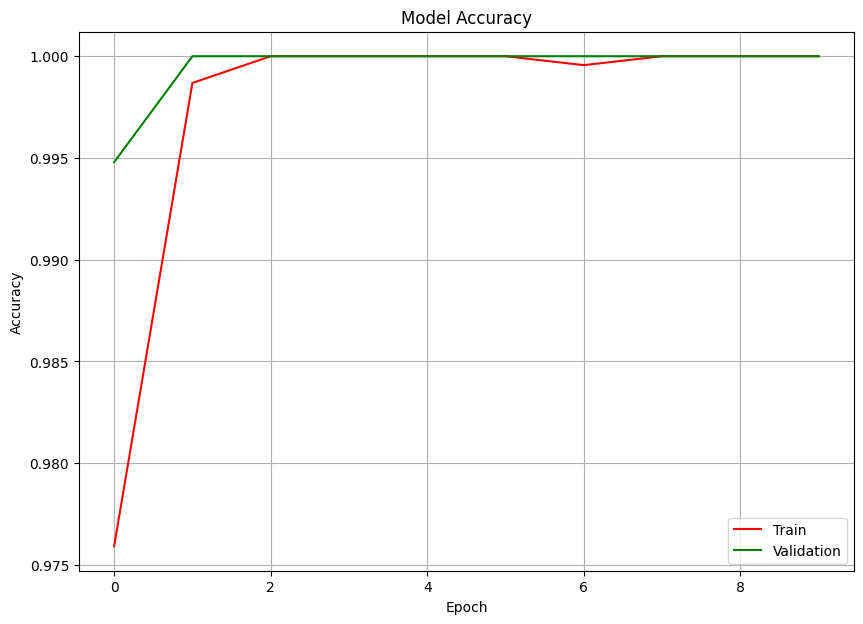

C:\Users\avisi\AppData\Local\Temp\ipykernel_20436\697373770.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


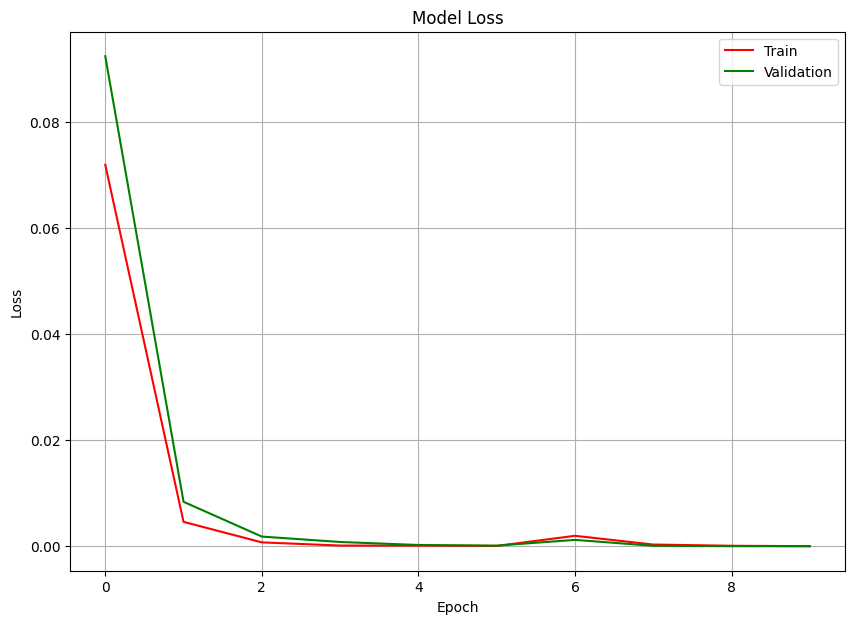

In [9]:
# Plot model accuracy
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(b=True)
plt.show()

# Plot model loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(b=True)
plt.show()
